Modelle vergleichen über CV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Mutual Information wird mit Korrelationsmatrix kombiniert und über Optuna-Optimierung werden die Variablen ausgewählt, die ROC-AUC optimieren.
CV: split=5, repeats=10; r=0,8


Ergebnisse der äußeren Cross-Validation (aggregiert):


,Gruppe,Train Accuracy,Test Accuracy,F1 Score,Recall,ROC-AUC,Anzahl-Features
0,Total,99.56 ± 0.73,86.74 ± 5.94,-,-,95.92 ± 3.54,41.72 ± 3.33
1,1 (Verletzte),-,-,87.23 ± 5.98,85.05 ± 9.86,95.92 ± 3.54,-



Verteilung der Evaluierungsmetriken (Boxplot):


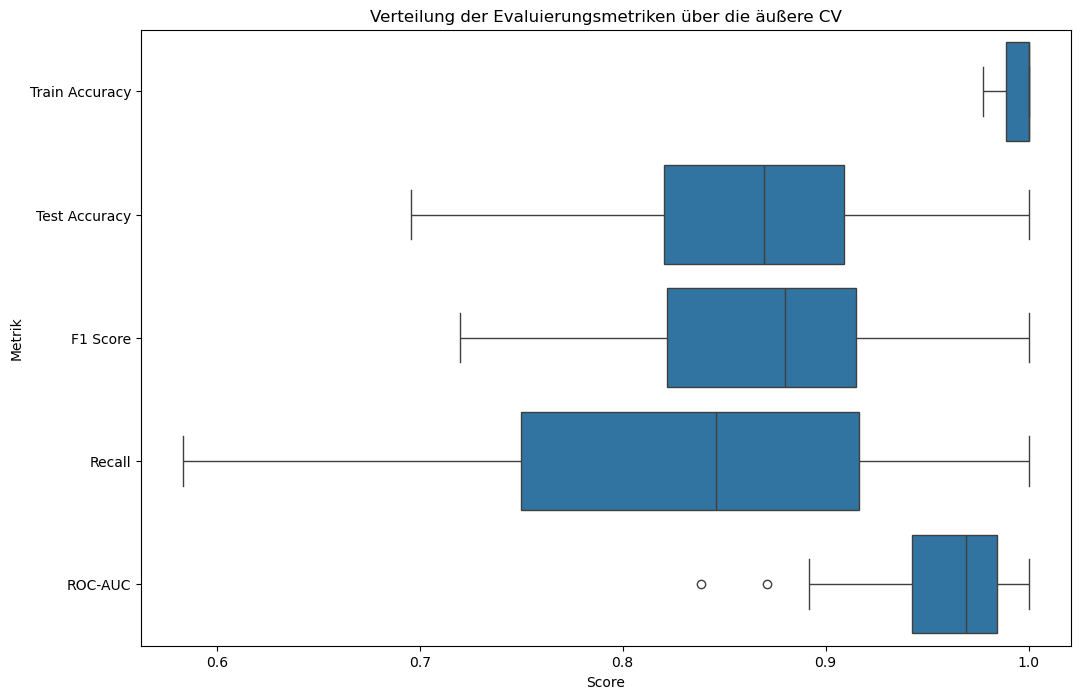

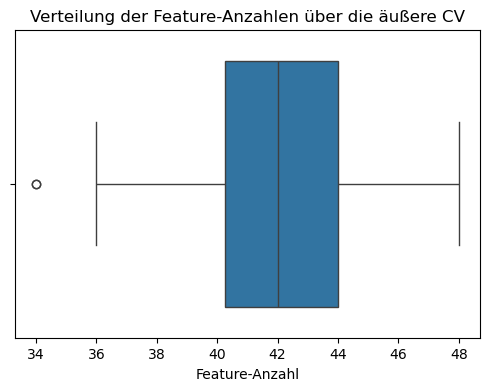


Häufigste verwendete Features:


,Feature,Häufigkeit
0,CMJ_Braking duration,50
1,CMJ_Countermovement Time,50
2,CMJ_Countermovement depth,50
3,CMJ_KAI con,50
4,CMJ_KAI ecc,50
5,CMJ_Landing KAI ecc,50
6,CMJ_Propulsive duration,50
7,CMJ_Vertical Stiffness,50
8,Geschlecht_weiblich,50
9,INV_CMJ_uni_Countermovement Time-Mittelwert [s],50



Durchschnittliche Anzahl nicht hochkorrelierter Features über alle inneren CVs: 47.55 ± 2.77


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display
from collections import Counter
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.8):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr().abs()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
    candidate_features = sorted(candidate_features)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, n_jobs=-1)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    best_num_features = []
    feature_counts = []  # Speichert die Anzahl der nicht hochkorrelierten Features pro Fold

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Berechne den Kandidatenpool
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        
        # Speicher die Anzahl der übrig gebliebenen Features
        feature_counts.append(len(candidate_features))
        
        # Falls der Kandidatenpool leer ist, setze alle Features ein
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
        
        def objective(trial):
            low_bound = 1
            high_bound = len(candidate_features)
            num_features = trial.suggest_int("num_features", low_bound, high_bound)
            X_selected = X_inner_train[candidate_features[:num_features]]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100, n_jobs=-1)
        best_num_features.append(study.best_trial.params["num_features"])
        
    # Berechnung von Median der besten Feature-Anzahl
    median_features = int(np.median(best_num_features))

    return median_features, feature_counts



def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    
    # Listen zum Sammeln der Metriken
    train_accuracies = []
    test_accuracies = []
    f1_scores = []
    recall_scores = []
    roc_auc_scores = []
    num_features = []
    selected_features_outer = []
    
    all_feature_counts = []  # Hier speichern wir die Anzahl der nicht hochkorrelierten Features aus allen inneren CV-Folds

    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        # Innere Cross-Validation zur Berechnung der durchschnittlichen Anzahl an Features
        avg_selected_features, feature_counts_inner = inner_cv_feature_selection(X_train, y_train)
        
        # Speichert alle Feature-Anzahlen der inneren CV-Folds über alle äußeren CV-Folds hinweg
        all_feature_counts.extend(feature_counts_inner)  # Hier fügen wir die Werte aus innerer CV hinzu
        
        # Optuna-Optimierung in der äußeren CV, basierend auf der durchschnittlichen Anzahl der Features
        candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        trial = optimize_feature_selection(X_train[candidate_features], y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        
        # Speichere die final ausgewählten Features für diesen Fold
        selected_features_outer.append(candidate_features[:num_features_optimized])
        
        X_train_optimized = X_train[candidate_features[:num_features_optimized]]
        X_test_optimized = X_test[candidate_features[:num_features_optimized]]

        # Logistische Regression auf den selektierten Features
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        # Vorhersagen
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test_optimized)

        # Berechnungen der Metriken
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_optimized)[:, 1])

        # Speichern der Metriken
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        roc_auc_scores.append(roc_auc)
        num_features.append(num_features_optimized)
    
    results_summary = {
        'Train Accuracy': np.mean(train_accuracies),
        'Train Accuracy Std': np.std(train_accuracies),
        'Test Accuracy': np.mean(test_accuracies),
        'Test Accuracy Std': np.std(test_accuracies),
        'F1-Score_1': np.mean(f1_scores),
        'F1-Score Std': np.std(f1_scores),
        'Recall_1': np.mean(recall_scores),
        'Recall Std': np.std(recall_scores),
        'ROC-AUC_1': np.mean(roc_auc_scores),
        'ROC-AUC Std': np.std(roc_auc_scores),
        'Feature-Anzahl': np.mean(num_features),
        'Feature-Anzahl Std': np.std(num_features)
    }

    raw_metrics = {
        "Train Accuracies": train_accuracies,
        "Test Accuracies": test_accuracies,
        "F1 Scores": f1_scores,
        "Recall Scores": recall_scores,
        "ROC-AUC Scores": roc_auc_scores,
        "Feature-Anzahlen": num_features
    }

    return results_summary, raw_metrics, selected_features_outer, all_feature_counts


def compute_feature_usage(selected_features_outer):
    # Flache Liste aller ausgewählten Features aus den einzelnen Folds erstellen
    all_selected_features = [feature for fold in selected_features_outer for feature in fold]
    # Häufigkeiten zählen
    feature_usage = Counter(all_selected_features)
    # Filter nur Features, die mindestens einmal vorkamen (was per Definition immer der Fall ist)
    most_common_features = feature_usage.most_common()
    return most_common_features

def compute_feature_stats(all_feature_counts):
    # Berechnung der durchschnittlichen Anzahl der nicht hochkorrelierten Features
    mean_features = np.mean(all_feature_counts)
    std_features = np.std(all_feature_counts)
    
    # Rückgabe der berechneten Werte
    return mean_features, std_features


def display_results_summary(results_summary):
    # Formatierte Metriken mit ± Standardabweichung
    formatted_metrics = {
        "Gruppe": ["Total", "1 (Verletzte)"],
        "Train Accuracy": [
            f"{results_summary['Train Accuracy']*100:.2f} ± {results_summary['Train Accuracy Std']*100:.2f}",
            "-"
        ],
        "Test Accuracy": [
            f"{results_summary['Test Accuracy']*100:.2f} ± {results_summary['Test Accuracy Std']*100:.2f}",
            "-"
        ],
        "F1 Score": [
            "-",
            f"{results_summary['F1-Score_1']*100:.2f} ± {results_summary['F1-Score Std']*100:.2f}"
        ],
        "Recall": [
            "-",
            f"{results_summary['Recall_1']*100:.2f} ± {results_summary['Recall Std']*100:.2f}"
        ],
        "ROC-AUC": [
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}",
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}"
            
        ],
        "Anzahl-Features": [
            f"{results_summary['Feature-Anzahl']:.2f} ± {results_summary['Feature-Anzahl Std']:.2f}",
            "-"
        ]
    }

    # Erstellen des DataFrames
    df = pd.DataFrame(formatted_metrics)

    # Formatierung des DataFrames für HTML-Ausgabe
    styled_df = df.style.set_properties(**{"text-align": "center", "color": "black"}) \
                        .set_table_styles([{
                            "selector": "th", 
                            "props": [("font-size", "14px"), 
                                      ("background-color", "#f2f2f2"), 
                                      ("color", "black")]
                        }]) \
                        .set_caption("Durchschnittliche Evaluierungsmetriken über die äußere CV")

    display(styled_df)


def plot_raw_metrics(raw_metrics):
    # Erstellen eines DataFrames für die fünf Metriken
    metrics_df = pd.DataFrame({
        "Train Accuracy": raw_metrics["Train Accuracies"],
        "Test Accuracy": raw_metrics["Test Accuracies"],
        "F1 Score": raw_metrics["F1 Scores"],
        "Recall": raw_metrics["Recall Scores"],
        "ROC-AUC": raw_metrics["ROC-AUC Scores"]
    })
    
    # Umwandlung in das Long-Format (tidy data)
    metrics_long = metrics_df.melt(var_name="Metrik", value_name="Wert")
    
    # Erstellen des Boxplots für die fünf Metriken
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Wert", y="Metrik", data=metrics_long)
    plt.xlabel("Score")
    plt.title("Verteilung der Evaluierungsmetriken über die äußere CV")
    plt.show()
    
    # Erstellen eines separaten DataFrames für die Feature-Anzahl
    features_df = pd.DataFrame({
        "Feature-Anzahl": raw_metrics["Feature-Anzahlen"]
    })
    
    # Erstellen eines separaten Boxplots für die Feature-Anzahl
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Feature-Anzahl", data=features_df)
    plt.xlabel("Feature-Anzahl")
    plt.title("Verteilung der Feature-Anzahlen über die äußere CV")
    plt.show()

def print_feature_importance_table(most_common_features):
    # Erstelle ein DataFrame aus dem Counter
    df_features = pd.DataFrame(most_common_features, columns=["Feature", "Häufigkeit"])
    # Formatierung der Tabelle
    styled_df = df_features.style.set_properties(**{"text-align": "center", "color": "black"}) \
                         .set_table_styles([{"selector": "th", 
                                              "props": [("font-size", "14px"), 
                                                        ("background-color", "#f2f2f2"), 
                                                        ("color", "black")]}]) \
                         .set_caption("Häufigste in der finalen Feature-Auswahl verwendete Features")
    display(styled_df)
    
def main():
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML _neu.xlsx"
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)
    
    results_summary, raw_metrics, selected_features_outer, all_feature_counts = cross_validate(X_scaled, y)
    
    print("\nErgebnisse der äußeren Cross-Validation (aggregiert):")
    display_results_summary(results_summary)
    
    print("\nVerteilung der Evaluierungsmetriken (Boxplot):")
    plot_raw_metrics(raw_metrics)
    
    # Berechne und zeige die Feature-Nutzung
    most_common_features = compute_feature_usage(selected_features_outer)
    print("\nHäufigste verwendete Features:")
    print_feature_importance_table(most_common_features)
    
    # Berechne die durchschnittliche Anzahl nicht hochkorrelierter Features und gib das Ergebnis aus
    mean_features, std_features = compute_feature_stats(all_feature_counts)
    print(f"\nDurchschnittliche Anzahl nicht hochkorrelierter Features über alle inneren CVs: {mean_features:.2f} ± {std_features:.2f}")

if __name__ == "__main__":
    main()


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_mutualinf_korr.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Modell wird validiert: Logistic Regression
Modell wird validiert: Decision Tree
Modell wird validiert: Random Forest
Modell wird validiert: Gradient Boosting
Modell wird validiert: XGBoost
Modell wird validiert: LightGBM
Modell wird validiert: SVC
Modell wird validiert: k-Nearest Neighbors
Modell wird validiert: MLP Classifier
Modell wird validiert: Gaussian Naive Bayes
Modell wird validiert: Linear Discriminant Analysis
Modell wird validiert: Quadratic Discriminant Analysis


C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Varia

Modell wird validiert: Bagging Classifier
Modell wird validiert: Extra Trees

Ergebnisse der Modelle:
                              Model   Train Accuracy    Test Accuracy       F1-Score_1         Recall_1        ROC-AUC_1
0               Logistic Regression  0.9980 ± 0.0042  0.8826 ± 0.0560  0.8863 ± 0.0576  0.8636 ± 0.1001  0.9731 ± 0.0230
8                    MLP Classifier  1.0000 ± 0.0000  0.8691 ± 0.0537  0.8747 ± 0.0569  0.8621 ± 0.1013  0.9511 ± 0.0339
6                               SVC  0.9631 ± 0.0095  0.8392 ± 0.0717  0.8501 ± 0.0728  0.8562 ± 0.1101  0.9469 ± 0.0366
4                           XGBoost  1.0000 ± 0.0000  0.8347 ± 0.0581  0.8407 ± 0.0616  0.8210 ± 0.1029  0.9381 ± 0.0343
9              Gaussian Naive Bayes  0.9166 ± 0.0151  0.8577 ± 0.0640  0.8660 ± 0.0632  0.8612 ± 0.0957  0.9354 ± 0.0524
5                          LightGBM  1.0000 ± 0.0000  0.8398 ± 0.0632  0.8460 ± 0.0638  0.8245 ± 0.1054  0.9354 ± 0.0409
13                      Extra Trees  1.0000 ± 0.000